In [1]:
from onnxruntime import InferenceSession
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F
import numpy as np


# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(token_embeddings, attention_mask):
    input_mask_expanded = np.expand_dims(attention_mask, -1) * np.ones_like(token_embeddings)
    return np.sum(token_embeddings * input_mask_expanded, axis=1) / np.clip(
        np.sum(input_mask_expanded, axis=1), a_min=1e-9, a_max=None
    )


MODEL_PATH = "../models/all-MiniLM-L6-v2/onnx/model_quint8_avx2.onnx"

session = InferenceSession(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained("../models/all-MiniLM-L6-v2")

In [2]:
sentences = ["This is an example sentence", "Each sentence is converted"]

batch = tokenizer(sentences, padding=True, truncation=True, return_tensors="np")

embs = session.run(
    None,
    {
        "input_ids": batch["input_ids"],
        "attention_mask": batch["attention_mask"],
        "token_type_ids": batch["token_type_ids"],
    },
)[0]
embs

array([[[ 0.0229758 ,  0.05715271,  0.19200966, ...,  0.04794327,
         -0.17276616, -0.29253587],
        [ 0.6739066 ,  0.67861265,  0.21898924, ...,  0.64984006,
          0.50383747,  0.54797447],
        [-0.08781619,  0.11483893,  0.00951756, ...,  0.5484041 ,
          1.292658  , -0.0536002 ],
        ...,
        [ 0.06317882, -0.10931629,  0.1641183 , ...,  1.0649678 ,
         -0.24734306,  0.38682726],
        [ 0.56428087,  0.6727148 ,  0.6885109 , ...,  0.15740068,
         -0.01031479, -1.470018  ],
        [ 0.86894244,  0.56108767,  0.4271511 , ..., -0.01039854,
          0.24263361, -0.8977083 ]],

       [[ 0.25407153,  0.10340537,  0.00386695, ...,  0.30044022,
         -0.1919257 , -0.3079437 ],
        [ 0.76602143,  0.50813293, -0.05059769, ...,  0.24616562,
          0.40794563, -0.23799741],
        [ 0.49302495,  0.68782   ,  0.6457227 , ...,  0.7894363 ,
          0.58389443, -1.2702867 ],
        ...,
        [ 0.5536508 ,  0.898712  , -0.4074525 , ...,  

In [3]:
mean_pooling(embs, batch["attention_mask"]).shape

(2, 384)

Running embedding benchmarks...
This may take a few minutes...
Testing batch_size=1, token_size=1
Testing batch_size=1, token_size=16
Testing batch_size=1, token_size=32
Testing batch_size=1, token_size=64
Testing batch_size=1, token_size=128
Testing batch_size=1, token_size=256
Testing batch_size=1, token_size=512
Testing batch_size=1, token_size=1024
Testing batch_size=2, token_size=1
Testing batch_size=2, token_size=16
Testing batch_size=2, token_size=32
Testing batch_size=2, token_size=64
Testing batch_size=2, token_size=128
Testing batch_size=2, token_size=256
Testing batch_size=2, token_size=512
Testing batch_size=2, token_size=1024
Testing batch_size=4, token_size=1
Testing batch_size=4, token_size=16
Testing batch_size=4, token_size=32
Testing batch_size=4, token_size=64
Testing batch_size=4, token_size=128
Testing batch_size=4, token_size=256
Testing batch_size=4, token_size=512
Testing batch_size=4, token_size=1024
Testing batch_size=8, token_size=1
Testing batch_size=8, toke

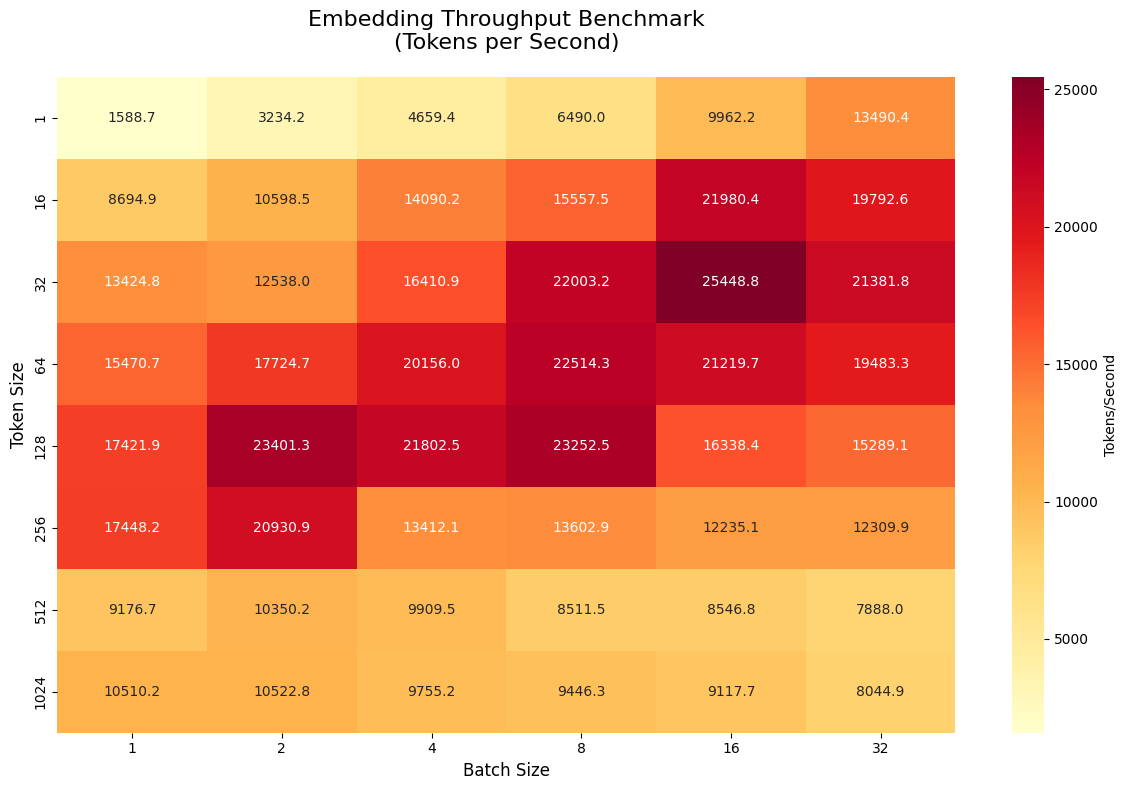


Detailed Results:
batch_size            1             2             4             8   \
token_size                                                           
1            1588.711396   3234.182902   4659.388643   6489.967893   
16           8694.860302  10598.516439  14090.212480  15557.507418   
32          13424.805227  12538.033216  16410.867516  22003.245720   
64          15470.735802  17724.680753  20156.040207  22514.304165   
128         17421.879134  23401.294398  21802.488299  23252.476116   
256         17448.200762  20930.875161  13412.057895  13602.942910   
512          9176.731512  10350.241578   9909.540540   8511.534845   
1024        10510.249703  10522.759213   9755.181235   9446.316900   

batch_size            16            32  
token_size                              
1            9962.224355  13490.393937  
16          21980.405341  19792.589524  
32          25448.829959  21381.762924  
64          21219.665501  19483.349993  
128         16338.404168  15289.08

In [5]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List


def generate_text_with_tokens(target_tokens: int) -> str:
    """Generate text with approximately the target number of tokens."""
    # Using simple repeated words to approximate token count
    # Most words are 1-2 tokens, so we'll use single words
    base_words = ["The", "quick", "brown", "fox", "jumps", "over", "lazy", "dog", "and", "runs", "through", "forest"]
    words = []
    current_tokens = 0

    while current_tokens < target_tokens:
        word = base_words[current_tokens % len(base_words)]
        words.append(word)
        current_tokens += 1  # Approximate 1 token per word

    return " ".join(words)


def benchmark_embedding(batch_size: int, token_length: int, num_runs: int = 5) -> float:
    """Benchmark embedding performance and return tokens per second."""
    # Generate text data
    text = generate_text_with_tokens(token_length)
    sentences = [text] * batch_size

    total_time = 0
    total_tokens = 0

    for _ in range(num_runs):
        # Tokenize
        start_time = time.time()
        batch = tokenizer(sentences, padding=True, truncation=True, return_tensors="np", max_length=512)

        # Run inference
        embs = session.run(
            None,
            {
                "input_ids": batch["input_ids"],
                "attention_mask": batch["attention_mask"],
                "token_type_ids": batch["token_type_ids"],
            },
        )[0]

        # Apply mean pooling
        sentence_embeddings = mean_pooling(embs, batch["attention_mask"])

        end_time = time.time()

        # Calculate actual tokens processed
        actual_tokens = np.sum(batch["attention_mask"])
        total_tokens += actual_tokens
        total_time += end_time - start_time

    # Return average tokens per second
    return total_tokens / total_time


# Benchmark parameters
batch_sizes = [1, 2, 4, 8, 16, 32]
token_sizes = [1, 16, 32, 64, 128, 256, 512, 1024]

print("Running embedding benchmarks...")
print("This may take a few minutes...")

# Store results
results = []

for batch_size in batch_sizes:
    for token_size in token_sizes:
        print(f"Testing batch_size={batch_size}, token_size={token_size}")
        throughput = benchmark_embedding(batch_size, token_size)
        results.append({"batch_size": batch_size, "token_size": token_size, "throughput_tokens_per_sec": throughput})

# Create DataFrame and pivot for heatmap
df = pd.DataFrame(results)
heatmap_data = df.pivot(index="token_size", columns="batch_size", values="throughput_tokens_per_sec")

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={"label": "Tokens/Second"})
plt.title("Embedding Throughput Benchmark\n(Tokens per Second)", fontsize=16, pad=20)
plt.xlabel("Batch Size", fontsize=12)
plt.ylabel("Token Size", fontsize=12)
plt.tight_layout()
plt.show()

# Also show raw numbers
print("\nDetailed Results:")
print(df.pivot(index="token_size", columns="batch_size", values="throughput_tokens_per_sec"))
